# **How often are appointments missed in the SNEE footprint?**

- This is required so that we can model the number of appointments missed, as this will require the patient to re-attend in the model at a later date.

- Are SNEE sub-ICB missed appointments greater than the national average (in FY 2022)?

- [using multiple years] Are the missed appointment %ages consistent over time (compare years, statistical tests)?

- Across staff groups & Sub-ICB, are some appointments more likely to be missed?

- Using the analysis from the above, what is the mean likelihood that someone (from a combination of)
    - Sub-ICB
    - Staff type
    - Appointment type
    - Will not attend?

- Suggest an appropriate distribution to sample from, to determine if a patient with the above appointment will attend.
Persist the distribution information from 5. to a yaml file.

prove andrew wrong - he believes NOrth east essex people do not attend appointments more as compared ot other two

### **Importing libraries**

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from schemas import DataCatalog
import constants as const
import seaborn as sns

### **Loading the catalog**

In [29]:
catalog =  DataCatalog.load_from_yaml("data_catalog.yaml")

### **Loading the dataset 'NHS GP Appointments by Region' for appointments data**

In [30]:
gp_appts_catalog_entry = catalog.single_data_sources[0]
gp_appts_df = gp_appts_catalog_entry.load()
print(gp_appts_catalog_entry.zip_file.namelist())

#Combining data for all the ICB's
dfs = []
for ccg_name in gp_appts_catalog_entry.zip_file.namelist():
    gp_appts_catalog_entry.csv_file = ccg_name
    dfs.append(gp_appts_catalog_entry.load())

combined_df = pd.concat(dfs, axis=0)
combined_df.head()

['Regional_CSV_WYorks.csv', 'Regional_CSV_Sussex.csv', 'Regional_CSV_SurreyHearts.csv', 'Regional_CSV_SuffolkNEEssex.csv', 'Regional_CSV_StaffsStoke.csv', 'Regional_CSV_Somerset.csv', 'Regional_CSV_ShropsTelfordWrekin.csv', 'Regional_CSV_SYorks.csv', 'Regional_CSV_SWLondon.csv', 'Regional_CSV_SELondon.csv', 'Regional_CSV_NottinghamNotts.csv', 'Regional_CSV_Northamptonshire.csv', 'Regional_CSV_NorfolkWaveney.csv', 'Regional_CSV_NWLondon.csv', 'Regional_CSV_NENCumbria.csv', 'Regional_CSV_NELondon.csv', 'Regional_CSV_NCLondon.csv', 'Regional_CSV_MidSEssex.csv', 'Regional_CSV_Lincolnshire.csv', 'Regional_CSV_LeicesterLshire.csv', 'Regional_CSV_LancsSCumbria.csv', 'Regional_CSV_KentMedway.csv', 'Regional_CSV_HumberNYorks.csv', 'Regional_CSV_HertfordshireWEssex.csv', 'Regional_CSV_HereWorcs.csv', 'Regional_CSV_HampshireIoW.csv', 'Regional_CSV_Gloucestershire.csv', 'Regional_CSV_GManchesterHSCP.csv', 'Regional_CSV_FrimleyHealth.csv', 'Regional_CSV_Dorset.csv', 'Regional_CSV_Devon.csv', 'Regio

,SUB_ICB_LOCATION_CODE,SUB_ICB_LOCATION_ONS_CODE,SUB_ICB_LOCATION_NAME,ICB_ONS_CODE,ICB_NAME,REGION_ONS_CODE,REGION_NAME,APPOINTMENT_MONTH,APPT_STATUS,HCP_TYPE,APPT_MODE,TIME_BETWEEN_BOOK_AND_APPT,COUNT_OF_APPOINTMENTS
0,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,1 Day,1999
1,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,15 to 21 Days,329
2,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,2 to 7 Days,4194
3,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,22 to 28 Days,212
4,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,8 to 14 Days,1101


In [31]:
combined_df['APPT_MODE'].unique()

array(['Face-to-Face', 'Home Visit', 'Telephone', 'Video/Online',
       'Unknown'], dtype=object)

#### **Data pre-processing**
1. Removing un-necessary columns and making a copy  
   
2. Changing APPOINTMENT_MONTH to FY_YEAR  
  
**Note: (FY2023 only from april to august)**

In [32]:
combined_df['APPOINTMENT_MONTH'].unique()

array(['MAR2021', 'APR2021', 'MAY2021', 'JUN2021', 'JUL2021', 'AUG2021',
       'SEP2021', 'OCT2021', 'NOV2021', 'DEC2021', 'JAN2022', 'FEB2022',
       'MAR2022', 'APR2022', 'MAY2022', 'JUN2022', 'JUL2022', 'AUG2022',
       'SEP2022', 'OCT2022', 'NOV2022', 'DEC2022', 'JAN2023', 'FEB2023',
       'MAR2023', 'APR2023', 'MAY2023', 'JUN2023', 'JUL2023', 'AUG2023'],
      dtype=object)

In [33]:
needed_cols = ['ICB_NAME','SUB_ICB_LOCATION_NAME','SUB_ICB_LOCATION_ONS_CODE','APPOINTMENT_MONTH','APPT_STATUS','HCP_TYPE','APPT_MODE','COUNT_OF_APPOINTMENTS']

combined_df_copy = combined_df[needed_cols].copy()

#Replacing months values to FY- years
combined_df_copy['APPOINTMENT_MONTH'] = combined_df_copy['APPOINTMENT_MONTH'].replace({'APR2021':'FY2021', 'MAY2021':'FY2021', 'JUN2021':'FY2021', 'JUL2021':'FY2021', 'AUG2021':'FY2021', 'SEP2021':'FY2021',
                                                                                       'OCT2021':'FY2021', 'NOV2021':'FY2021', 'DEC2021':'FY2021', 'JAN2022':'FY2021', 'FEB2022':'FY2021', 'MAR2022':'FY2021',
                                                                                       'APR2022':'FY2022', 'MAY2022':'FY2022', 'JUN2022':'FY2022', 'JUL2022':'FY2022', 'AUG2022':'FY2022', 'SEP2022':'FY2022',
                                                                                       'OCT2022':'FY2022', 'NOV2022':'FY2022', 'DEC2022':'FY2022', 'JAN2023':'FY2022', 'FEB2023':'FY2022', 'MAR2023':'FY2022',
                                                                                       'APR2023':'FY2023', 'MAY2023':'FY2023', 'JUN2023':'FY2023', 'JUL2023':'FY2023', 'AUG2023':'FY2023'})

combined_df_copy = combined_df_copy.loc[combined_df_copy['APPOINTMENT_MONTH']!='MAR2021'].rename(columns={'APPOINTMENT_MONTH':'FY_YEAR'})
combined_df_copy['FY_YEAR'].unique()

array(['FY2021', 'FY2022', 'FY2023'], dtype=object)

## **Analysis using mean of appointments**

### **Creating separate DF's for Attend and DNA appointments based on FY-YEARS**

In [34]:
#Dataframe for appointments attended
attended_df = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'Attended'].drop(columns=['SUB_ICB_LOCATION_NAME','SUB_ICB_LOCATION_ONS_CODE','APPT_STATUS','HCP_TYPE','APPT_MODE']).groupby(['ICB_NAME','FY_YEAR']).mean().round(4)
attended_df.head()

COUNT_OF_APPOINTMENTS
ICB_NAME                                           FY_YEAR                       
NHS Bath and North East Somerset, Swindon and W... FY2021               6441.2406
                                                   FY2022               6409.7105
                                                   FY2023               5193.6111
NHS Bedfordshire, Luton and Milton Keynes Integ... FY2021               6031.7656
                                                   FY2022               6074.6977

In [35]:
#Dataframe for appointments DNA
do_not_attend_df = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'DNA'].drop(columns=['SUB_ICB_LOCATION_NAME','SUB_ICB_LOCATION_ONS_CODE','APPT_STATUS','HCP_TYPE','APPT_MODE']).groupby(['ICB_NAME','FY_YEAR']).mean().round(4)
do_not_attend_df.head()

COUNT_OF_APPOINTMENTS
ICB_NAME                                           FY_YEAR                       
NHS Bath and North East Somerset, Swindon and W... FY2021                296.6420
                                                   FY2022                297.7442
                                                   FY2023                216.5930
NHS Bedfordshire, Luton and Milton Keynes Integ... FY2021                303.7700
                                                   FY2022                349.3905

### **Comparing the National average with SNEE**

#### **1. Attended appointments**

In [36]:
National_average_attended = attended_df['COUNT_OF_APPOINTMENTS'].mean().round(4)
National_average_attended_2022 = attended_df.loc[slice(None),'FY2022',:].mean().round(4)
SNEE_average_attended = attended_df.loc['NHS Suffolk and North East Essex Integrated Care Board',:]

print(f'{National_average_attended.item()} is the National average for attended appointments(FY-2021-22-23)')
print(f'{SNEE_average_attended.mean().item()} is the SNEE average for attended appointments(FY-2021-22-23)')
print(f'{National_average_attended_2022.item()} is the national average for attended appointments(FY-2022)')

SNEE_average_attended

4414.3347 is the National average for attended appointments(FY-2021-22-23)
2067.6403 is the SNEE average for attended appointments(FY-2021-22-23)
4763.7655 is the national average for attended appointments(FY-2022)


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,2187.6634
FY2022,2178.0886
FY2023,1837.1689


#### **2. Not attended (DNA) Appointments**

In [37]:
National_average_DNA = do_not_attend_df['COUNT_OF_APPOINTMENTS'].mean().round(4)
National_average_DNA_2022 = do_not_attend_df.loc[slice(None),'FY2022',:].mean().round(4)
SNEE_average_DNA = do_not_attend_df.loc['NHS Suffolk and North East Essex Integrated Care Board',:]

print(f'{National_average_DNA.item()} is the National average for DNA appointments (FY-2021-22-23)')
print(f'{SNEE_average_DNA.mean().item()} is the SNEE average for DNA appointments(FY-2021-22-23)')
print(f'{National_average_DNA_2022.item()} is the National average DNA attend appointments(FY-2022)')

SNEE_average_DNA

304.1467 is the National average for DNA appointments (FY-2021-22-23)
101.2273 is the SNEE average for DNA appointments(FY-2021-22-23)
334.4385 is the National average DNA attend appointments(FY-2022)


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,106.1100
FY2022,106.1922
FY2023,91.3797


### **Plotting the mean appointments for attended and non-attended based on FY-Years**

<Axes: xlabel='ICB_NAME', ylabel='Average of DNA Appointments'>

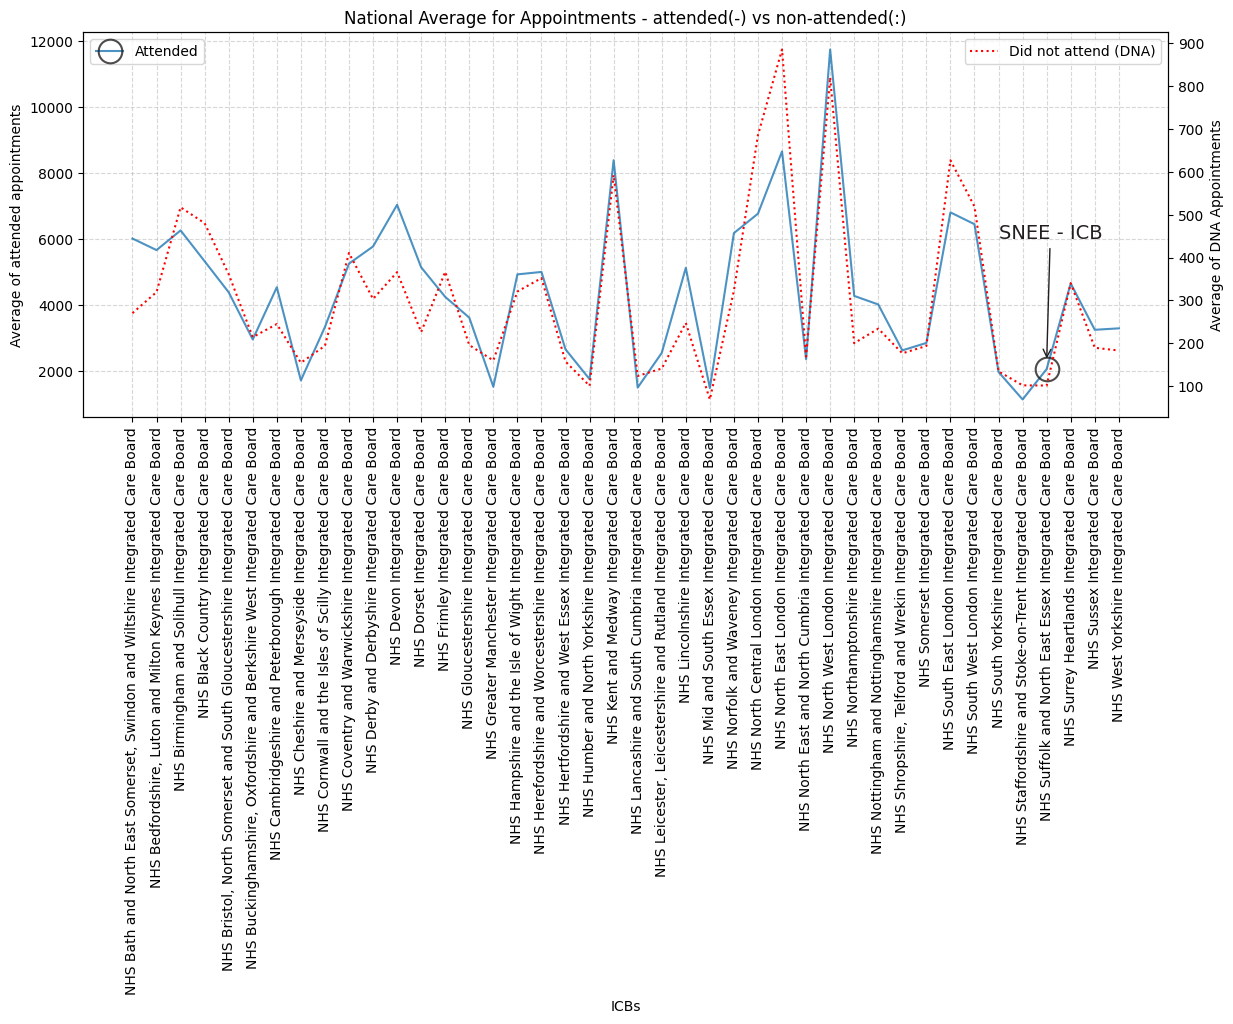

In [38]:
attended_df2 = attended_df.groupby('ICB_NAME').mean().reset_index()
do_not_attend_df2 = do_not_attend_df.groupby('ICB_NAME').mean().reset_index()
snee = 'NHS Suffolk and North East Essex Integrated Care Board'

#Plotting attended vs dna for FY-2021-22-23
plt.subplots(figsize=(14,5))
plt.xticks(rotation=90)
plt.xlabel('ICBs')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylabel('Average of attended appointments')
plt.title('National Average for Appointments - attended(-) vs non-attended(:)')
ax = sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=attended_df2, label = 'Attended', alpha=0.8, marker = 'o', markersize=17, fillstyle='none', markeredgewidth=1.5, markeredgecolor='#231f20', markevery=[38])
ax.annotate('SNEE - ICB',xy=(38,2300), xytext=(36,6000), arrowprops =dict(arrowstyle='->',color='#231f20'),color='#231f20', fontsize=14)
ax.legend(loc = 'upper left')

#Creating secondary y-axis
ax2 = ax.twinx()
ax2.set_ylabel('Average of DNA Appointments')
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS', data=do_not_attend_df2, color ='red', linestyle=':', ax=ax2, label ='Did not attend (DNA)')

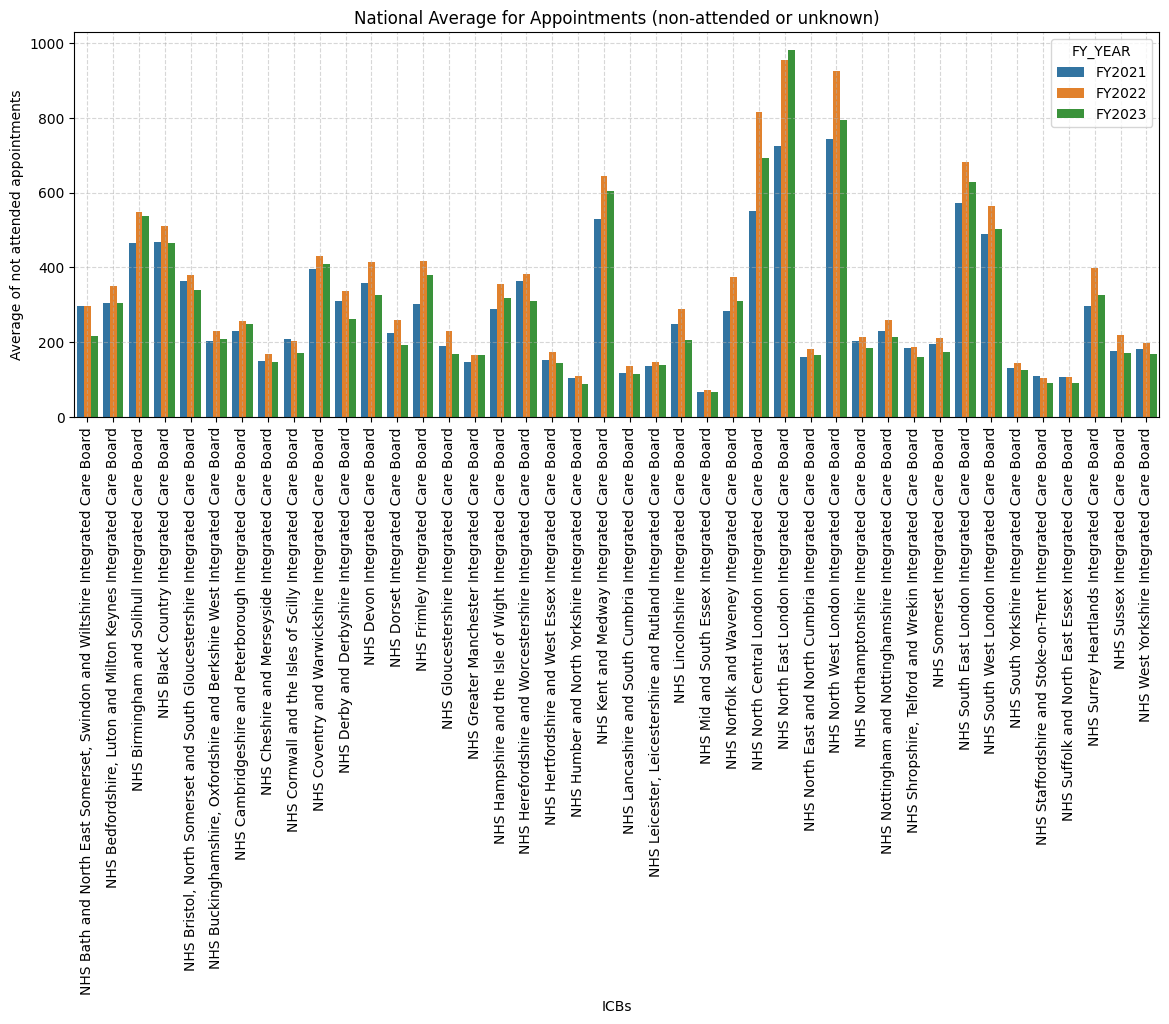

In [39]:
#Plotting the did not attended 
plt.subplots(figsize=(14,5))
plt.xticks(rotation=90)
sns.barplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS', data=do_not_attend_df, hue='FY_YEAR')
plt.xlabel('ICBs')
plt.ylabel('Average of not attended appointments')
plt.title('National Average for Appointments (non-attended or unknown)')
plt.grid(True, linestyle='--', alpha=0.5)

### **Creating separate DF's for Attend and DNA appointments based on HCP-type and Appointment-mode**

In [40]:
#Dataframe for appointments attended
attended_hcptype_apptmode = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'Attended'].drop(columns=['SUB_ICB_LOCATION_NAME','SUB_ICB_LOCATION_ONS_CODE','APPT_STATUS','FY_YEAR']).groupby(['ICB_NAME','HCP_TYPE','APPT_MODE']).mean().round(4)
attended_hcptype_apptmode

COUNT_OF_APPOINTMENTS
ICB_NAME                                           HCP_TYPE APPT_MODE                          
NHS Bath and North East Somerset, Swindon and W... GP       Face-to-Face             14436.9871
                                                            Home Visit                 142.7819
                                                            Telephone                11148.2478
                                                            Unknown                     23.3611
                                                            Video/Online               102.5330
...                                                                                         ...
NHS West Yorkshire Integrated Care Board           Unknown  Face-to-Face                66.9141
                                                            Home Visit                  19.0409
                                                            Telephone                  342.0952
                                                            Unknown                    915.0151
                                                            Video/Online                28.3333

[600 rows x 1 columns]

In [41]:
#Dataframe for appointments DNA
dna_hcptype_apptmode = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'DNA'].drop(columns=['SUB_ICB_LOCATION_NAME','SUB_ICB_LOCATION_ONS_CODE','APPT_STATUS','FY_YEAR']).groupby(['ICB_NAME','HCP_TYPE','APPT_MODE']).mean().round(4)
dna_hcptype_apptmode

COUNT_OF_APPOINTMENTS
ICB_NAME                                           HCP_TYPE             APPT_MODE                          
NHS Bath and North East Somerset, Swindon and W... GP                   Face-to-Face               393.8976
                                                                        Home Visit                   4.1333
                                                                        Telephone                   47.4483
                                                                        Unknown                      2.0000
                                                                        Video/Online                 3.2604
...                                                                                                     ...
NHS West Yorkshire Integrated Care Board           Other Practice staff Video/Online                 9.1938
                                                   Unknown              Face-to-Face                 1.3333
                                                                        Home Visit                   1.6000
                                                                        Telephone                    7.4348
                                                                        Unknown                     30.2217

[564 rows x 1 columns]

### **Plotting the mean DNA apointments based on HCP-TYPE and APPOINTMENT MODE**

In [42]:
#Calculating National average for GP's for DNA Appointments
DNA_GP_f2f = dna_hcptype_apptmode.loc[(slice(None),'GP','Face-to-Face'),:].mean().round(4).item()
DNA_GP_homevisit = dna_hcptype_apptmode.loc[(slice(None),'GP','Home Visit'),:].mean().round(4).item()
DNA_GP_tel = dna_hcptype_apptmode.loc[:,'GP','Telephone'].mean().round(4).item()
DNA_GP_unknown = dna_hcptype_apptmode.loc[:,'GP','Unknown'].mean().round(4).item()
DNA_GP_video_online = dna_hcptype_apptmode.loc[:,'GP','Video/Online'].mean().round(4).item()

#Calculating National average for Other Practice staff for DNA Appointments
DNA_p_staff_f2f = dna_hcptype_apptmode.loc[(slice(None),'Other Practice staff','Face-to-Face'),:].mean().round(4).item()
DNA_p_staff_homevisit = dna_hcptype_apptmode.loc[(slice(None),'Other Practice staff','Home Visit'),:].mean().round(4).item()
DNA_p_staff_tel = dna_hcptype_apptmode.loc[:,'Other Practice staff','Telephone'].mean().round(4).item()
DNA_p_staff_unknown = dna_hcptype_apptmode.loc[:,'Other Practice staff','Unknown'].mean().round(4).item()
DNA_p_staff_video_online = dna_hcptype_apptmode.loc[:,'Other Practice staff','Video/Online'].mean().round(4).item()

#Calculating National average for Unknown for DNA Appointments
DNA_unknown_f2f = dna_hcptype_apptmode.loc[(slice(None),'Unknown','Face-to-Face'),:].mean().round(4).item()
DNA_unknown_homevisit = dna_hcptype_apptmode.loc[(slice(None),'Unknown','Home Visit'),:].mean().round(4).item()
DNA_unknown_tel = dna_hcptype_apptmode.loc[:,'Unknown','Telephone'].mean().round(4).item()
DNA_unknown_unknown = dna_hcptype_apptmode.loc[:,'Unknown','Unknown'].mean().round(4).item()
DNA_unknown_video_online = dna_hcptype_apptmode.loc[:,'Unknown','Video/Online'].mean().round(4).item()


data = {
    'GP' : [DNA_GP_f2f, DNA_GP_homevisit, DNA_GP_tel, DNA_GP_unknown, DNA_GP_video_online],
    'Practice staff' : [DNA_p_staff_f2f, DNA_p_staff_homevisit, DNA_p_staff_tel, DNA_p_staff_unknown, DNA_p_staff_video_online],
    'Unknown' : [DNA_unknown_f2f, DNA_unknown_homevisit, DNA_unknown_tel, DNA_unknown_unknown, DNA_unknown_video_online]
}

index_values = ['Face to face', 'Home visit', 'Telephone', 'Unknown', 'Video/Online']

national_average_dna_hcp_appt_type = pd.DataFrame(data, index=index_values)
national_average_dna_hcp_appt_type

,GP,Practice staff,Unknown
Face to face,522.9799,1445.7924,10.2775
Home visit,7.4150,7.3712,9.2554
Telephone,217.4651,176.0907,17.7065
Unknown,12.6657,21.3622,36.2917
Video/Online,6.7932,13.2985,1.7222


In [43]:
dna_hcptype_apptmode.loc['NHS Suffolk and North East Essex Integrated Care Board',:,:]

COUNT_OF_APPOINTMENTS
HCP_TYPE             APPT_MODE                          
GP                   Face-to-Face               110.8551
                     Home Visit                   2.8230
                     Telephone                   28.0365
                     Unknown                      2.3548
                     Video/Online                 5.2594
Other Practice staff Face-to-Face               526.5491
                     Home Visit                   3.8621
                     Telephone                   29.3931
                     Unknown                      2.8772
                     Video/Online                14.4883
Unknown              Face-to-Face               161.2398
                     Home Visit                   1.7079
                     Telephone                    1.7381
                     Unknown                     21.8283

<Axes: >

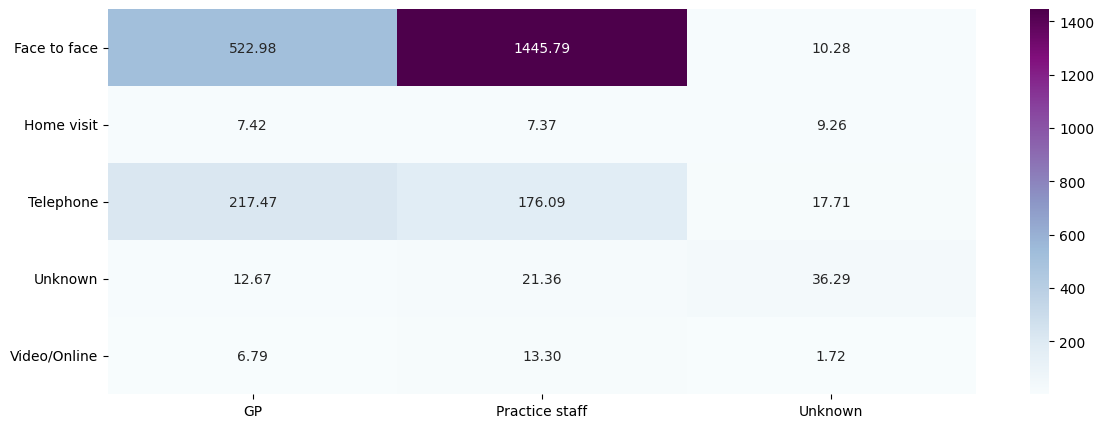

In [44]:
plt.subplots(figsize=(14,5))
sns.heatmap(national_average_dna_hcp_appt_type, annot=True, fmt='.2f', cmap='BuPu')

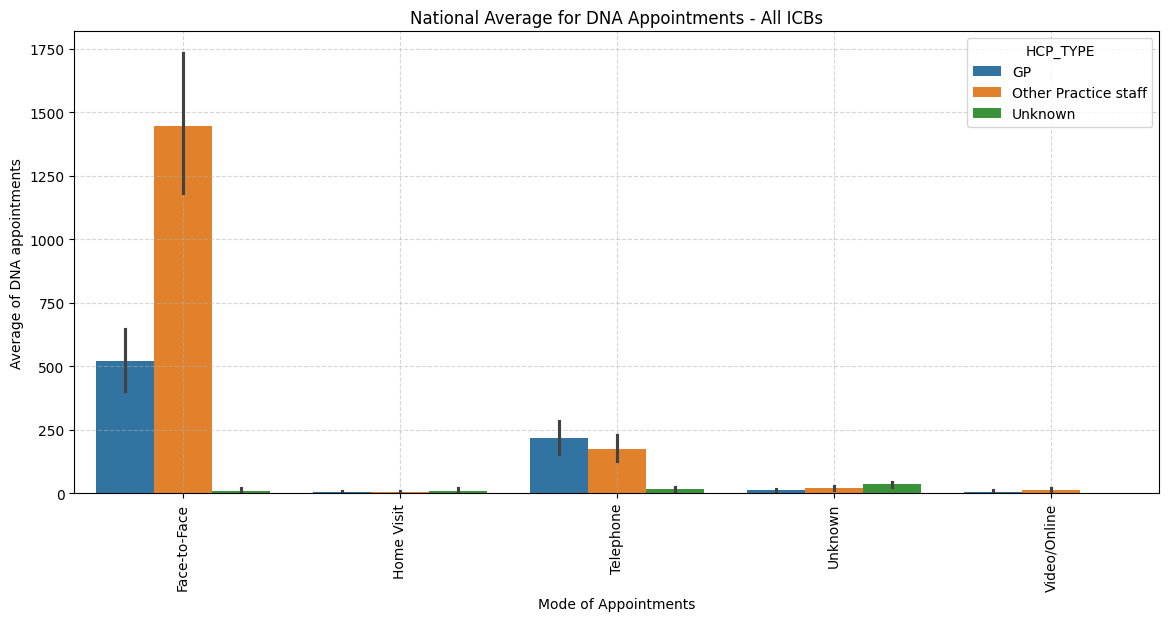

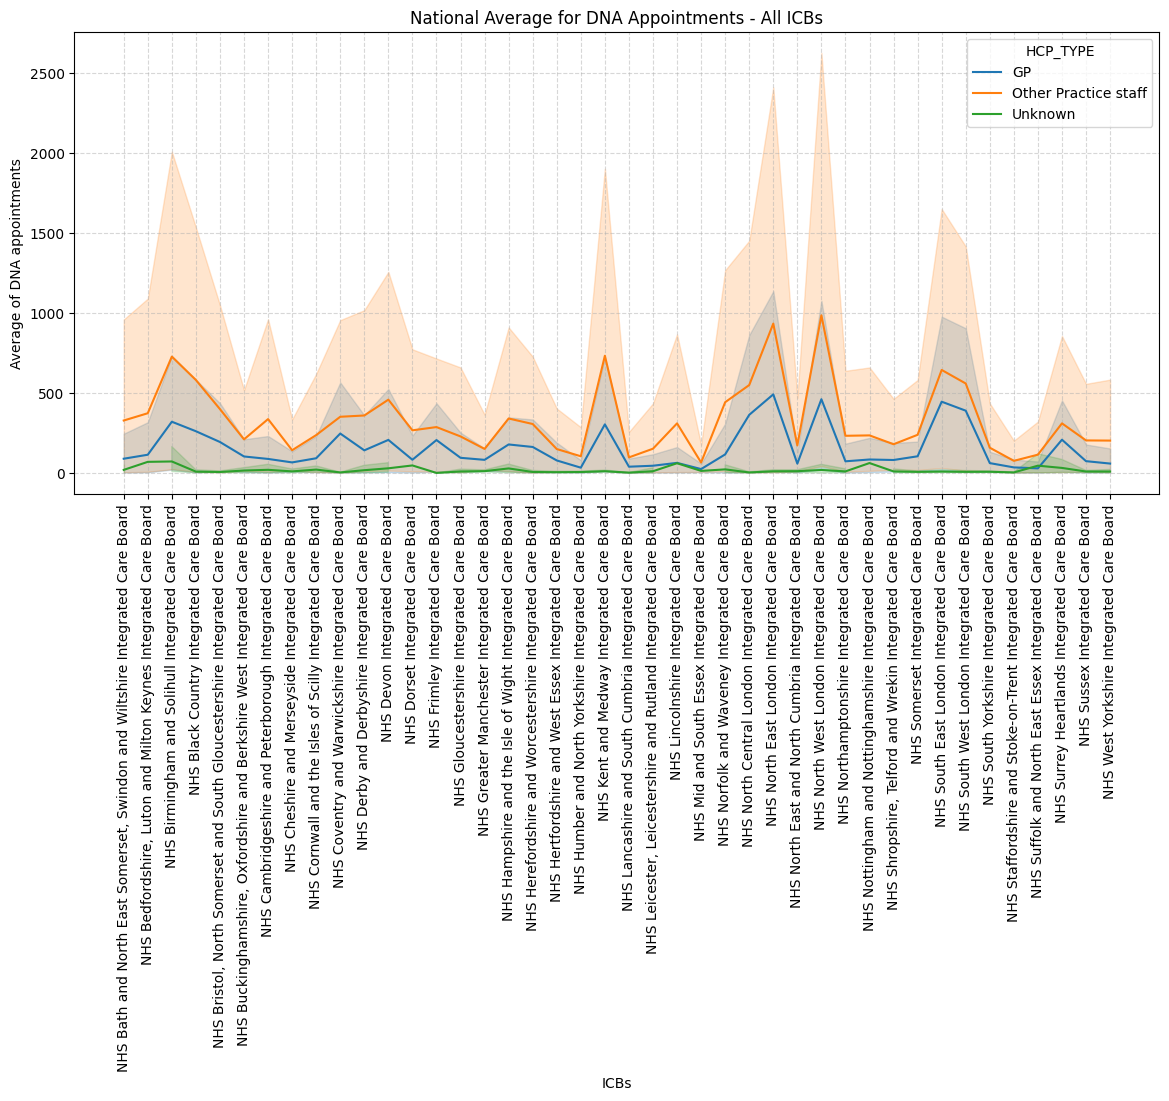

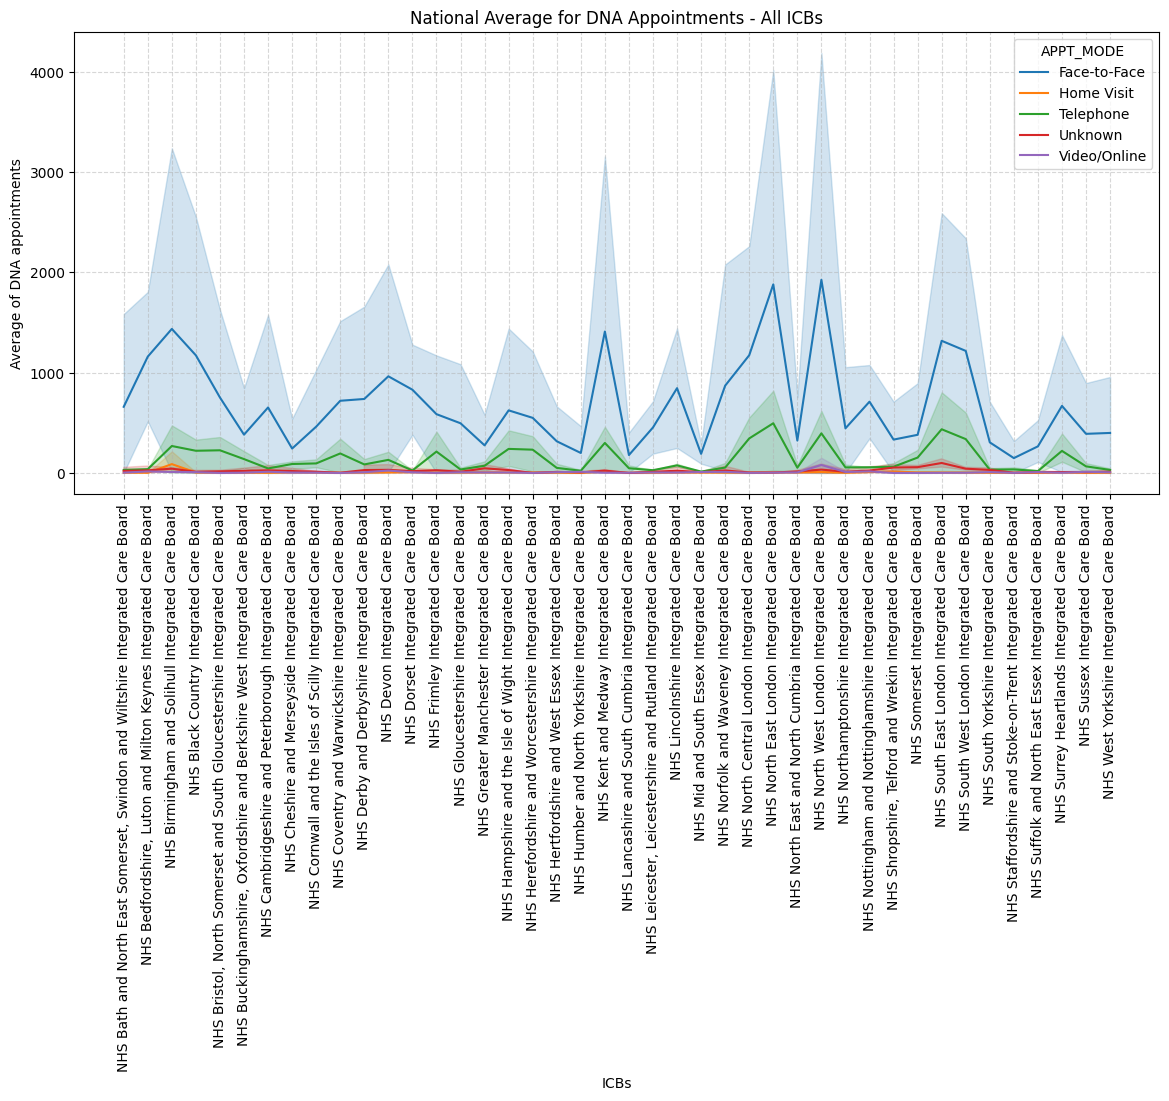

In [45]:
#Plotting the DNA appointments barplot
plt.subplots(figsize=(14,6))
plt.xticks(rotation=90)
sns.barplot(x='APPT_MODE', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='HCP_TYPE')
plt.xlabel('Mode of Appointments')
plt.ylabel('Average of DNA appointments')
plt.title('National Average for DNA Appointments - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

#Plotting the DNA appointments lineplot
plt.subplots(figsize=(14,6))
plt.xticks(rotation=90)
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='HCP_TYPE')
plt.xlabel('ICBs')
plt.ylabel('Average of DNA appointments')
plt.title('National Average for DNA Appointments - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

#Plotting the DNA appointments lineplot
plt.subplots(figsize=(14,6))
plt.xticks(rotation=90)
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='APPT_MODE')
plt.xlabel('ICBs')
plt.ylabel('Average of DNA appointments')
plt.title('National Average for DNA Appointments - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

## **Analysis using proportion(%) of appointments**

### **Pre-Processing**

In [132]:
appt_proportion_df = combined_df_copy.loc[:,['SUB_ICB_LOCATION_NAME','HCP_TYPE','APPT_MODE','APPT_STATUS','COUNT_OF_APPOINTMENTS','FY_YEAR']].pivot_table(index=['SUB_ICB_LOCATION_NAME','HCP_TYPE','APPT_MODE','FY_YEAR'], columns=['APPT_STATUS'], values=['COUNT_OF_APPOINTMENTS'], aggfunc='sum')

# Converting number of attended/dna/unknown to proportions
sum_row = appt_proportion_df.sum(axis=1)
appt_proportion_df = appt_proportion_df.div(sum_row, axis=0)*100
appt_proportion_df

COUNT_OF_APPOINTMENTS  \
APPT_STATUS                                                                                   Attended   
SUB_ICB_LOCATION_NAME                              HCP_TYPE APPT_MODE    FY_YEAR                         
NHS Bath and North East Somerset Swindon and Wi... GP       Face-to-Face FY2021              95.485783   
                                                                         FY2022              95.485204   
                                                                         FY2023              93.195754   
                                                            Home Visit   FY2021              94.723969   
                                                                         FY2022              96.491228   
...                                                                                                ...   
NHS West Yorkshire ICB - X2C4Y                     Unknown  Face-to-Face FY2021              99.456522   
                                                                         FY2022                    NaN   
                                                            Unknown      FY2021              89.345778   
                                                                         FY2022              88.608142   
                                                                         FY2023              88.166040   

                                                                                            \
APPT_STATUS                                                                            DNA   
SUB_ICB_LOCATION_NAME                              HCP_TYPE APPT_MODE    FY_YEAR             
NHS Bath and North East Somerset Swindon and Wi... GP       Face-to-Face FY2021   2.096193   
                                                                         FY2022   2.369269   
                                                                         FY2023   2.505296   
                                                            Home Visit   FY2021   2.480783   
                                                                         FY2022   1.682778   
...                                                                                    ...   
NHS West Yorkshire ICB - X2C4Y                     Unknown  Face-to-Face FY2021        NaN   
                                                                         FY2022        NaN   
                                                            Unknown      FY2021   2.918405   
                                                                         FY2022   3.069003   
                                                                         FY2023   2.371214   

                                                                                              
APPT_STATUS                                                                          Unknown  
SUB_ICB_LOCATION_NAME                              HCP_TYPE APPT_MODE    FY_YEAR              
NHS Bath and North East Somerset Swindon and Wi... GP       Face-to-Face FY2021     2.418024  
                                                                         FY2022     2.145526  
                                                                         FY2023     4.298949  
                                                            Home Visit   FY2021     2.795248  
                                                                         FY2022     1.825994  
...                                                                                      ...  
NHS West Yorkshire ICB - X2C4Y                     Unknown  Face-to-Face FY2021     0.543478  
                                                                         FY2022   100.000000  
                                                            Unknown      FY2021     7.735817  
                                                                         FY2022     8.322854  
                                            

In [133]:
appt_proportion_df = appt_proportion_df.reset_index()
appt_proportion_df.columns = ['SUB_ICB_LOCATION_NAME','HCP_TYPE','APPT_MODE','FY_YEAR','Attended','DNA','Unknown']
appt_proportion_df

,SUB_ICB_LOCATION_NAME,HCP_TYPE,APPT_MODE,FY_YEAR,Attended,DNA,Unknown
0,NHS Bath and North East Somerset Swindon and W...,GP,Face-to-Face,FY2021,95.485783,2.096193,2.418024
1,NHS Bath and North East Somerset Swindon and W...,GP,Face-to-Face,FY2022,95.485204,2.369269,2.145526
2,NHS Bath and North East Somerset Swindon and W...,GP,Face-to-Face,FY2023,93.195754,2.505296,4.298949
3,NHS Bath and North East Somerset Swindon and W...,GP,Home Visit,FY2021,94.723969,2.480783,2.795248
4,NHS Bath and North East Somerset Swindon and W...,GP,Home Visit,FY2022,96.491228,1.682778,1.825994
...,...,...,...,...,...,...,...
3968,NHS West Yorkshire ICB - X2C4Y,Unknown,Face-to-Face,FY2021,99.456522,NaN,0.543478
3969,NHS West Yorkshire ICB - X2C4Y,Unknown,Face-to-Face,FY2022,NaN,NaN,100.000000
3970,NHS West Yorkshire ICB - X2C4Y,Unknown,Unknown,FY2021,89.345778,2.918405,7.735817
3971,NHS West Yorkshire ICB - X2C4Y,Unknown,Unknown,FY2022,88.608142,3.069003,8.322854


### 1. **Attended Appointments** 

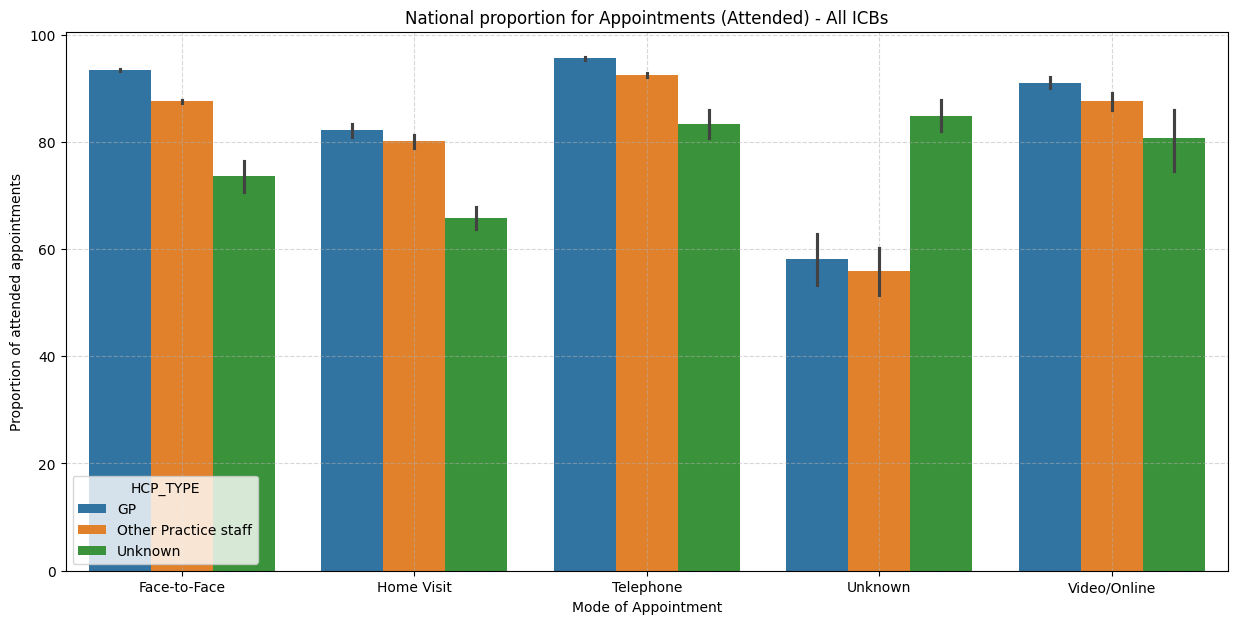

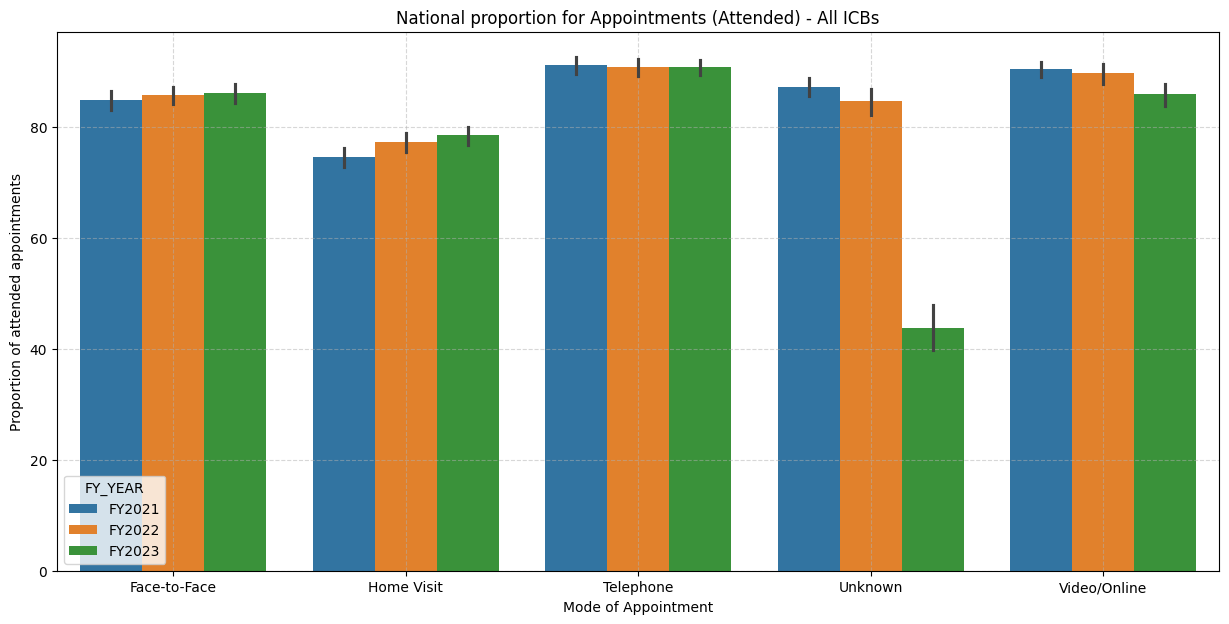

In [85]:
#Plotting the Attended appointments by HCP type
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='Attended', hue='HCP_TYPE',  data=appt_proportion_df)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of attended appointments')
plt.title('National proportion for Appointments (Attended) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)


#Plotting the Attended appointments by FY Years
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='Attended', hue='FY_YEAR',  data=appt_proportion_df)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of attended appointments')
plt.title('National proportion for Appointments (Attended) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

### 2. **DNA Appointments** 

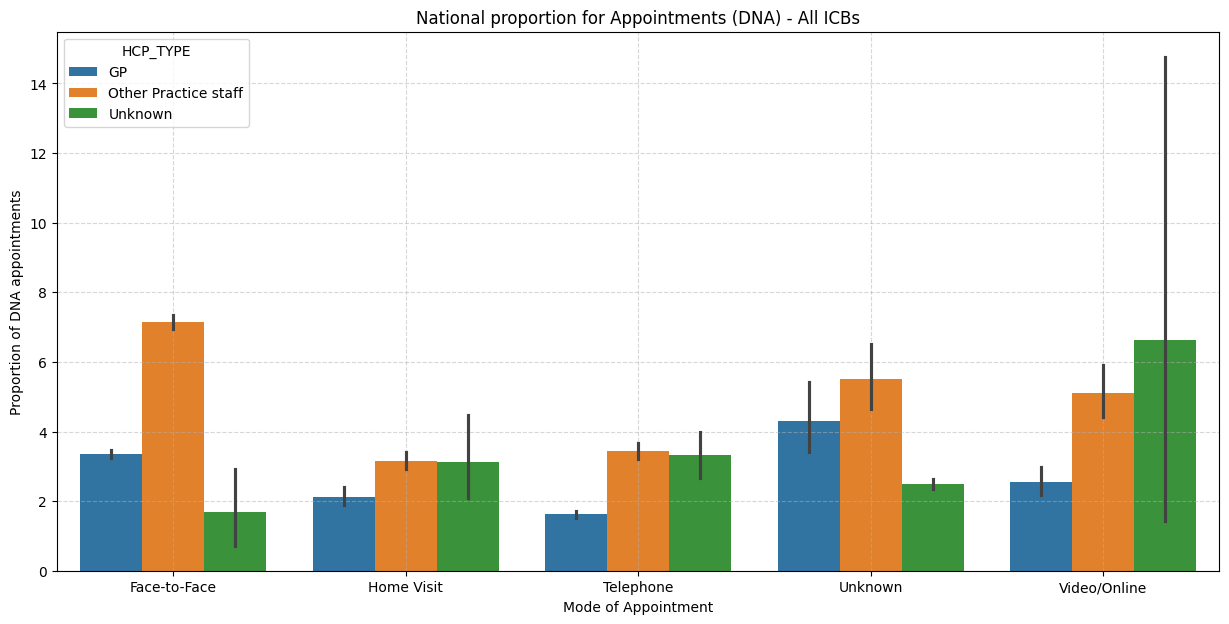

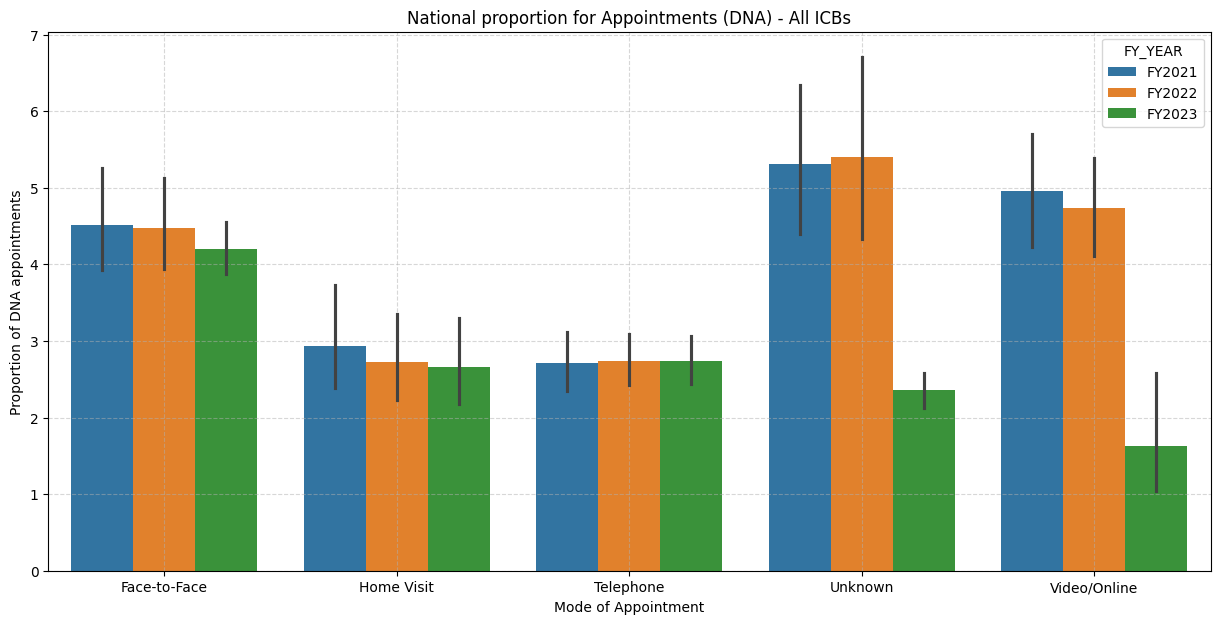

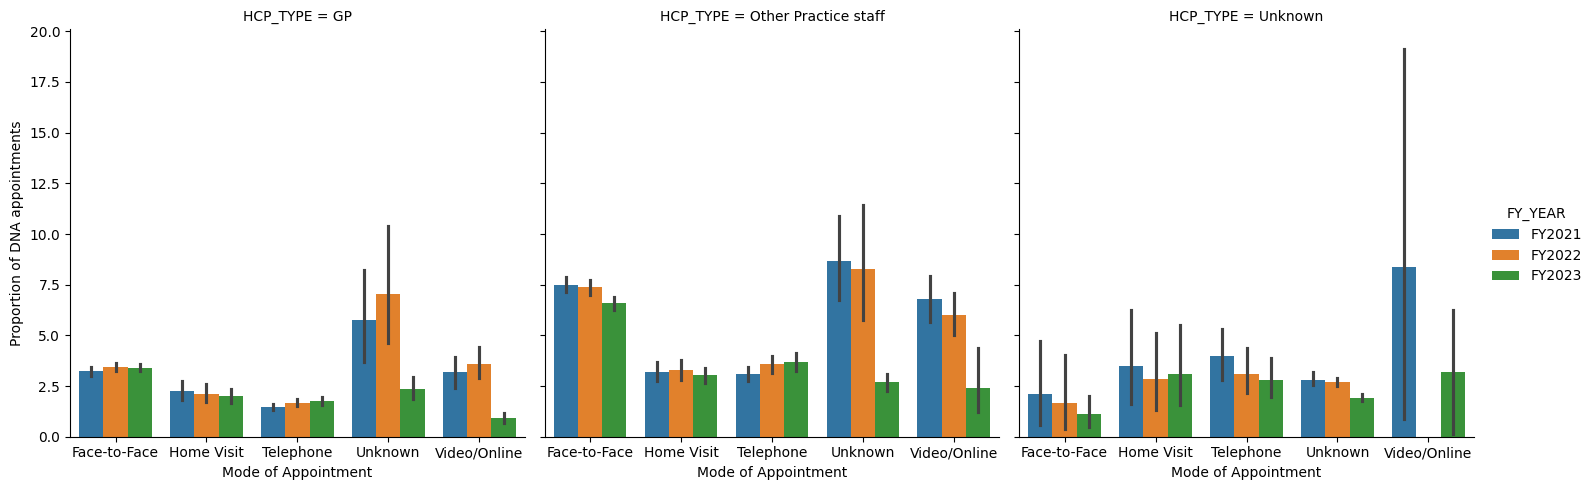

In [87]:
#Plotting the Attended appointments by HCP type
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='DNA', hue='HCP_TYPE',  data=appt_proportion_df)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)


#Plotting the Attended appointments by FY Year
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='DNA', hue='FY_YEAR',  data=appt_proportion_df)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

#Plotting the Attended appointments by FY Year
fig = sns.catplot(x='APPT_MODE', y='DNA', hue='FY_YEAR', col='HCP_TYPE' , kind='bar', data=appt_proportion_df)
fig.set_xlabels('Mode of Appointment')
fig.set_ylabels('Proportion of DNA appointments')
plt.show()

### **SNEE sub-icb Analysis**

In [143]:
snee_sub_icb = ['NHS Suffolk and North East Essex ICB - 06L','NHS Suffolk and North East Essex ICB - 06T','NHS Suffolk and North East Essex ICB - 07K']
snee_appt_proportion_df = appt_proportion_df.loc[appt_proportion_df['SUB_ICB_LOCATION_NAME'].isin(snee_sub_icb)]
snee_appt_proportion_df['SUB_ICB_LOCATION_NAME'] = snee_appt_proportion_df['SUB_ICB_LOCATION_NAME'].replace({'NHS Suffolk and North East Essex ICB - 06L':'Ipswich & East Suffolk',
                                                                                                             'NHS Suffolk and North East Essex ICB - 06T':'North East Essex',
                                                                                                             'NHS Suffolk and North East Essex ICB - 07K':'West Suffolk'})
snee_appt_proportion_df = snee_appt_proportion_df.groupby(['SUB_ICB_LOCATION_NAME','HCP_TYPE','APPT_MODE','FY_YEAR']).mean()
snee_appt_proportion_df

/tmp/ipykernel_3849/2546951300.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snee_appt_proportion_df['SUB_ICB_LOCATION_NAME'] = snee_appt_proportion_df['SUB_ICB_LOCATION_NAME'].replace({'NHS Suffolk and North East Essex ICB - 06L':'Ipswich & East Suffolk',


Attended       DNA  \
SUB_ICB_LOCATION_NAME  HCP_TYPE APPT_MODE    FY_YEAR                         
Ipswich & East Suffolk GP       Face-to-Face FY2021    96.076500  1.353280   
                                             FY2022    95.111481  1.627623   
                                             FY2023    93.971259  1.591765   
                                Home Visit   FY2021    95.251319  2.402111   
                                             FY2022    94.611727  2.073428   
...                                                          ...       ...   
West Suffolk           Unknown  Telephone    FY2022   100.000000       NaN   
                                             FY2023          NaN       NaN   
                                Unknown      FY2021    96.118702  1.430525   
                                             FY2022    94.421558  1.966858   
                                             FY2023    93.489261  1.481826   

                                                         Unknown  
SUB_ICB_LOCATION_NAME  HCP_TYPE APPT_MODE    FY_YEAR              
Ipswich & East Suffolk GP       Face-to-Face FY2021     2.570220  
                                             FY2022     3.260895  
                                             FY2023     4.436976  
                                Home Visit   FY2021     2.346570  
                                             FY2022     3.314844  
...                                                          ...  
West Suffolk           Unknown  Telephone    FY2022          NaN  
                                             FY2023   100.000000  
                                Unknown      FY2021     2.450773  
                                             FY2022     3.611584  
                                             FY2023     5.028914  

[111 rows x 3 columns]

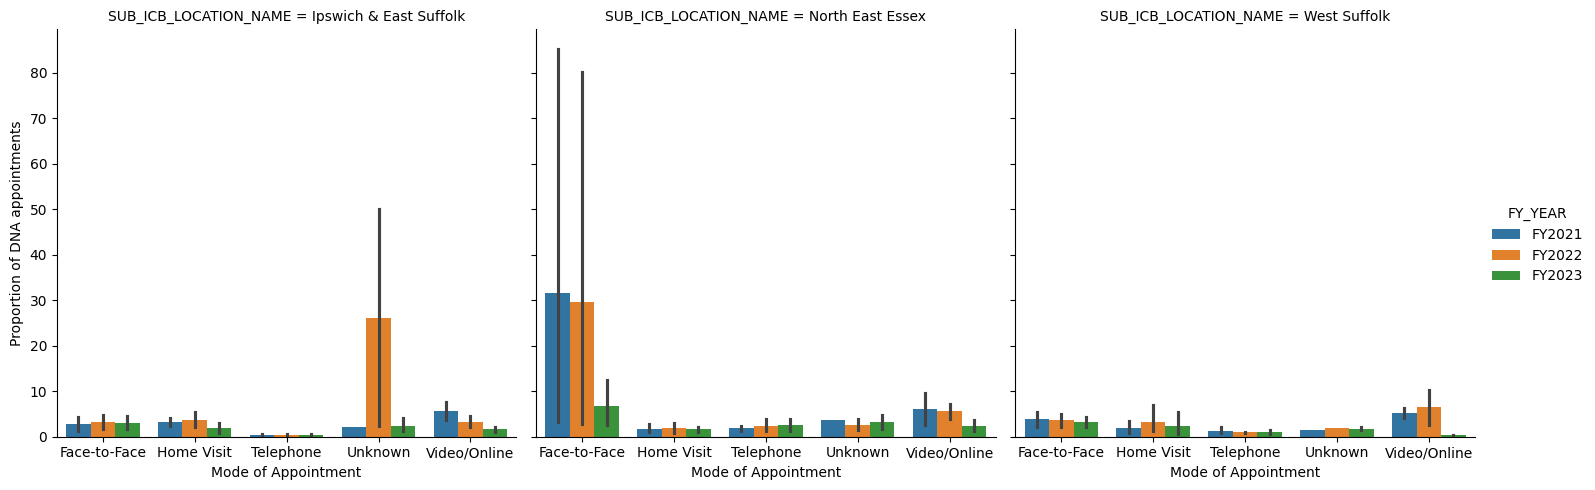

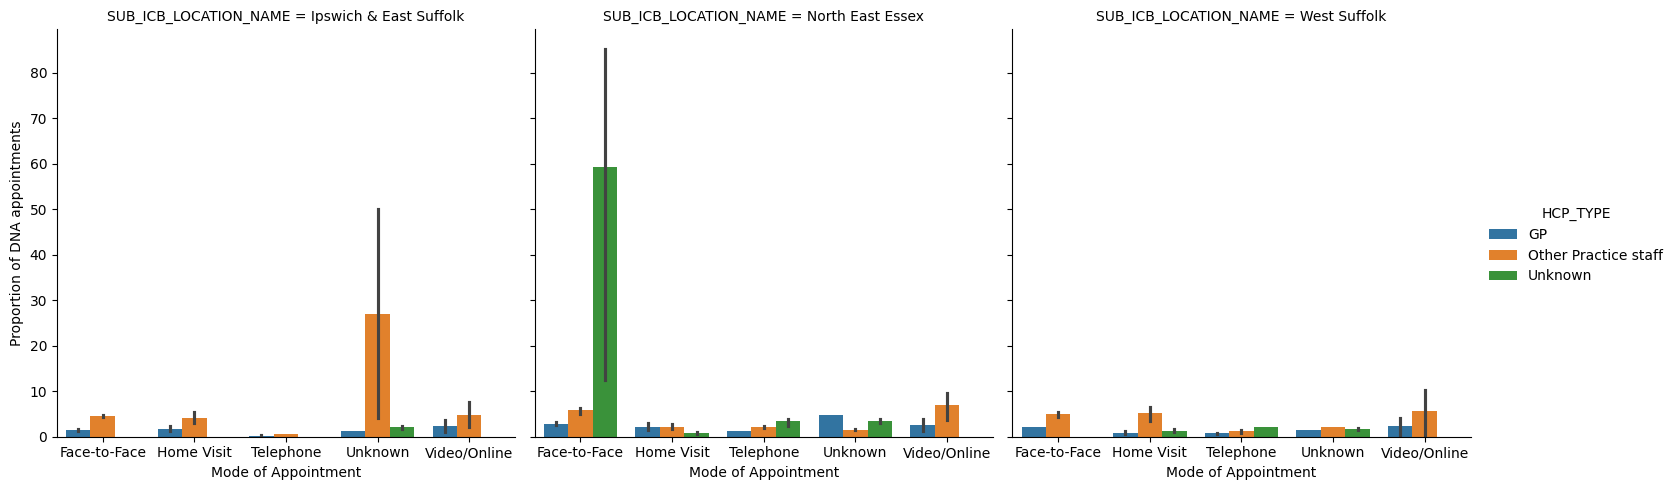

In [144]:
#Plotting the Attended appointments by FY Year
fig = sns.catplot(x='APPT_MODE', y='DNA', hue='FY_YEAR', col='SUB_ICB_LOCATION_NAME' , kind='bar', data=snee_appt_proportion_df)
fig.set_xlabels('Mode of Appointment')
fig.set_ylabels('Proportion of DNA appointments')
plt.show()

#Plotting the Attended appointments by FY Year
fig = sns.catplot(x='APPT_MODE', y='DNA', hue='HCP_TYPE', col='SUB_ICB_LOCATION_NAME' , kind='bar', data=snee_appt_proportion_df)
fig.set_xlabels('Mode of Appointment')
fig.set_ylabels('Proportion of DNA appointments')
plt.show()

### **Correlation matrix**

In [146]:
snee_appt_proportion_df

Attended       DNA  \
SUB_ICB_LOCATION_NAME  HCP_TYPE APPT_MODE    FY_YEAR                         
Ipswich & East Suffolk GP       Face-to-Face FY2021    96.076500  1.353280   
                                             FY2022    95.111481  1.627623   
                                             FY2023    93.971259  1.591765   
                                Home Visit   FY2021    95.251319  2.402111   
                                             FY2022    94.611727  2.073428   
...                                                          ...       ...   
West Suffolk           Unknown  Telephone    FY2022   100.000000       NaN   
                                             FY2023          NaN       NaN   
                                Unknown      FY2021    96.118702  1.430525   
                                             FY2022    94.421558  1.966858   
                                             FY2023    93.489261  1.481826   

                                                         Unknown  
SUB_ICB_LOCATION_NAME  HCP_TYPE APPT_MODE    FY_YEAR              
Ipswich & East Suffolk GP       Face-to-Face FY2021     2.570220  
                                             FY2022     3.260895  
                                             FY2023     4.436976  
                                Home Visit   FY2021     2.346570  
                                             FY2022     3.314844  
...                                                          ...  
West Suffolk           Unknown  Telephone    FY2022          NaN  
                                             FY2023   100.000000  
                                Unknown      FY2021     2.450773  
                                             FY2022     3.611584  
                                             FY2023     5.028914  

[111 rows x 3 columns]

In [149]:
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder

#snee_appt_proportion_df = snee_appt_proportion_df.reset_index()
ce_OHE = ce.OneHotEncoder(cols=['SUB_ICB_LOCATION_NAME','HCP_TYPE','APPT_MODE','FY_YEAR'])
data1 = ce_OHE.fit_transform(snee_appt_proportion_df)
data1.head()

,SUB_ICB_LOCATION_NAME_1,SUB_ICB_LOCATION_NAME_2,SUB_ICB_LOCATION_NAME_3,HCP_TYPE_1,HCP_TYPE_2,HCP_TYPE_3,APPT_MODE_1,APPT_MODE_2,APPT_MODE_3,APPT_MODE_4,APPT_MODE_5,FY_YEAR_1,FY_YEAR_2,FY_YEAR_3,Attended,DNA,Unknown
0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,96.076500,1.353280,2.570220
1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,95.111481,1.627623,3.260895
2,1,0,0,1,0,0,1,0,0,0,0,0,0,1,93.971259,1.591765,4.436976
3,1,0,0,1,0,0,0,1,0,0,0,1,0,0,95.251319,2.402111,2.346570
4,1,0,0,1,0,0,0,1,0,0,0,0,1,0,94.611727,2.073428,3.314844


In [160]:
corr_matrix = data1.corr()
corr_matrix_dna = corr_matrix['DNA']
corr_matrix_dna

SUB_ICB_LOCATION_NAME_1   -0.041996
SUB_ICB_LOCATION_NAME_2    0.162989
SUB_ICB_LOCATION_NAME_3   -0.128406
HCP_TYPE_1                -0.196048
HCP_TYPE_2                 0.009638
HCP_TYPE_3                 0.220149
APPT_MODE_1                0.283448
APPT_MODE_2               -0.113701
APPT_MODE_3               -0.147838
APPT_MODE_4                0.014059
APPT_MODE_5               -0.028370
FY_YEAR_1                  0.039300
FY_YEAR_2                  0.114362
FY_YEAR_3                 -0.149205
Attended                  -0.577497
DNA                        1.000000
Unknown                   -0.019996
Name: DNA, dtype: float64

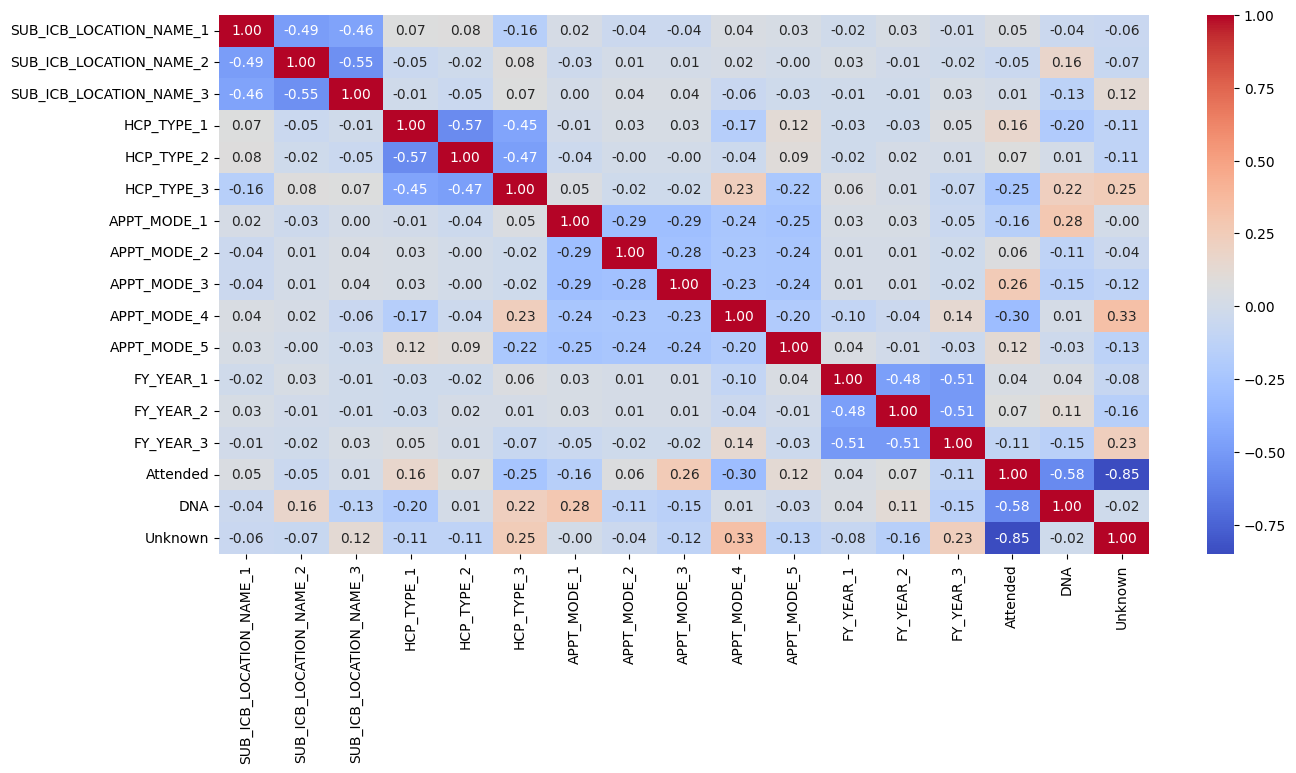

In [162]:
plt.subplots(figsize=(15,7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

## **Inferences and Results**

### 1. Are SNEE sub-ICB missed appointments greater than the national average (in FY 2022)?

In [51]:
print(f'{National_average_DNA.item()} is the National average for DNA appointments (FY-2021-22-23)')
print(f'{SNEE_average_DNA.mean().item()} is the SNEE average for DNA appointments(FY-2021-22-23)')
print(f'{National_average_DNA_2022.item()} is the National average DNA attend appointments(FY-2022)')

SNEE_average_DNA

304.1467 is the National average for DNA appointments (FY-2021-22-23)
101.2273 is the SNEE average for DNA appointments(FY-2021-22-23)
334.4385 is the National average DNA attend appointments(FY-2022)


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,106.1100
FY2022,106.1922
FY2023,91.3797


- We can see that the overall average for non-attended appointments for SNEE-ICB is 101, which is much lesser than National Average of 304
  
- For year 2022, this difference increases as the National average increases from 304 to 334, whereas for SNEE-ICB the change is from 101 to 106

### 2. Are the missed appointments proportion (%) consistent over time using multiple years?

- The missed appointments are consistent over years when appointment mode is Face to Face, home visit or telephonic
- The missed appointments are not consistent over years when appointment mode is UNknown or Video/ONline

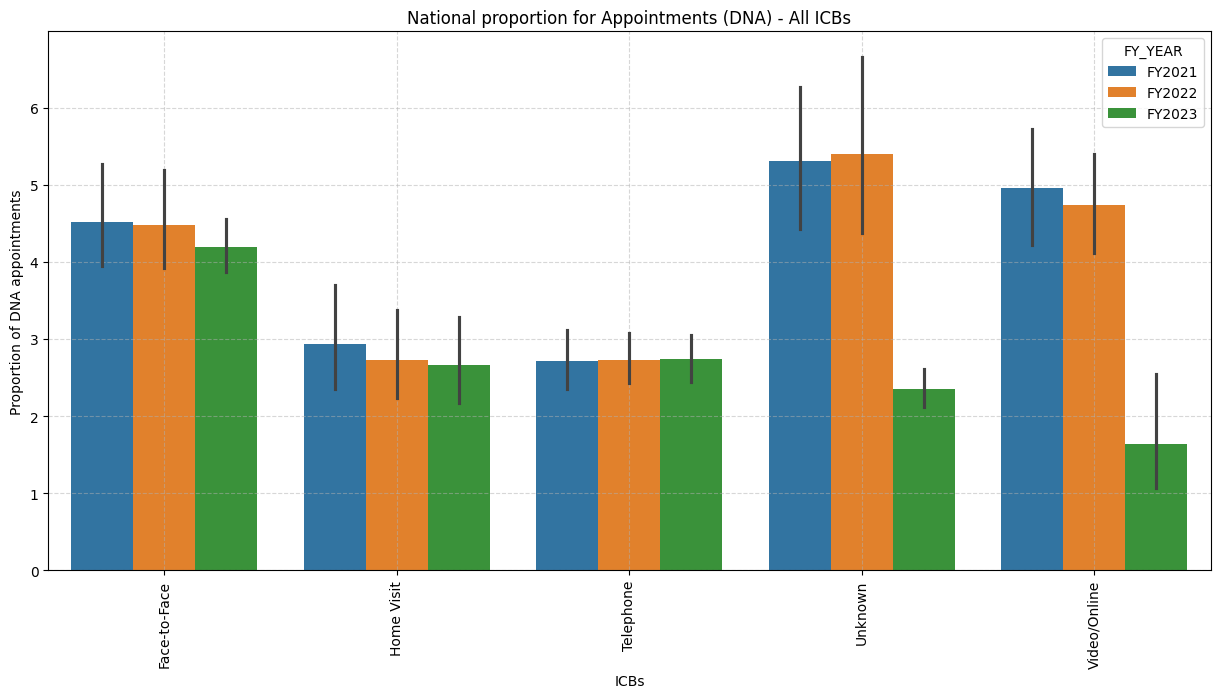

In [52]:
#Plotting the Attended appointments by FY Year
plt.subplots(figsize=(15,7))
plt.xticks(rotation=90)
sns.barplot(x='APPT_MODE', y='DNA', hue='FY_YEAR',  data=appt_proportion_df)
plt.xlabel('ICBs')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

### 3. Across staff groups & Sub-ICB, are some appointments more likely to be missed?


- Appointments that are with 'other practice staff' are most likely to be missed specially when mode of appointments is Face to Face, followed by UNknown

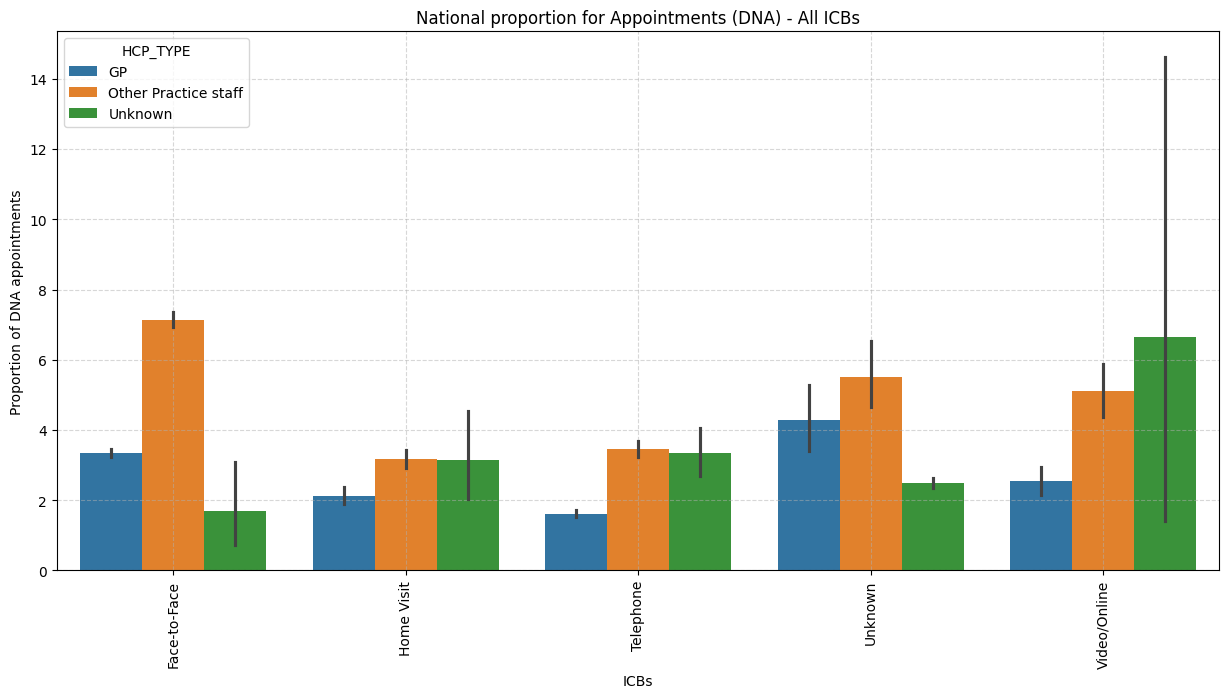

In [53]:
#Plotting the Attended appointments by HCP type
plt.subplots(figsize=(15,7))
plt.xticks(rotation=90)
sns.barplot(x='APPT_MODE', y='DNA', hue='HCP_TYPE',  data=appt_proportion_df)
plt.xlabel('ICBs')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

### 4. What is the mean likelihood that someone  Will not attend? from a combination of Sub-ICB, Staff type, Appointment type.

In [163]:
corr_matrix_dna

SUB_ICB_LOCATION_NAME_1   -0.041996
SUB_ICB_LOCATION_NAME_2    0.162989
SUB_ICB_LOCATION_NAME_3   -0.128406
HCP_TYPE_1                -0.196048
HCP_TYPE_2                 0.009638
HCP_TYPE_3                 0.220149
APPT_MODE_1                0.283448
APPT_MODE_2               -0.113701
APPT_MODE_3               -0.147838
APPT_MODE_4                0.014059
APPT_MODE_5               -0.028370
FY_YEAR_1                  0.039300
FY_YEAR_2                  0.114362
FY_YEAR_3                 -0.149205
Attended                  -0.577497
DNA                        1.000000
Unknown                   -0.019996
Name: DNA, dtype: float64